# Исследование пользовательского поведения в мобильном приложении

**Описание проекта**. В данном проекте проведено исследование пользовательского поведения в мобильном приложении стартапа, занимающегося продажей продуктов питания. Изучена воронка событий, определён порядок их выполнения и рассчитана конверсия между событиями. Проведено A/A/B-тестирование, в котором оценивается влияние изменений шрифтов в приложении на пользовательское поведение.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**План работы**:

1. Загрузить файл с данными и изучить общую информацию.
2. Провести предобработку данных: проверить данные на пропуски, дубликаты, преобразовать названия столбцов и типы данных.
3. Проверить данные: за все ли дни мы обладаем полными данными, выделить актуальный период, проверить распределение на группы. 
4. Изучить воронку событий и выяснить, сколько пользователей переходят на каждый её этап и доходят до конца. 
5. Провести A/A/B-тест и определить, повлияло ли изменение шрифтов на поведение пользователей: есть ли статистически значимое различие между контрольными и экспериментальными группами. Учесть множественный характер теста в выборе уровня значимости. 

## Загрузка данных и импорт библиотек

In [1]:
# импортируем нужные библиотеки
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
from matplotlib import pyplot as plt
import datetime as dt
import seaborn as sns
import plotly.express as px 
from plotly import graph_objects as go

In [2]:
# прочитаем данные
data = pd.read_csv('C:/Users/alkon/practicum_projects/app_funnel_project/logs_exp.csv', sep='\t')
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
# выведем общую информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Предобработка данных

In [4]:
# проверим данные на пропуски и дубликаты
print('\033[1mКоличество явных дубликатов:\033[0m', data.duplicated().sum())
print('\033[1mКоличество пропусков:\n\033[0m', data.isna().sum())

Количество явных дубликатов: 413
Количество пропусков:
 EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


Видим, что в данных отсутствуют пропуски, но есть дубликаты, которые нужно удалить из датафрейма. Тип данных в столбце с датой приведём из строки в дату. Названия столбцов приведём к змеиному регистру. 

In [5]:
# удалим строки дубликаты 
data = data.drop_duplicates().reset_index(drop=True)
print('\033[1mКоличество явных дубликатов:\033[0m', data.duplicated().sum())

Количество явных дубликатов: 0


In [6]:
# замена названий столбцов
data.columns = ['event_name', 'user_id', 'event_timestamp', 'group']

In [7]:
# преобразование столбца с датой и временем
data['event_datetime'] = pd.to_datetime(data['event_timestamp'], unit='s')
# добавляем столбцец с датой
data['event_date'] = data['event_datetime'].astype('datetime64[D]')

In [8]:
# проверка типов данных
print(data.dtypes)

event_name                 object
user_id                     int64
event_timestamp             int64
group                       int64
event_datetime     datetime64[ns]
event_date         datetime64[ns]
dtype: object


In [9]:
# создание списка пользователей, входящих в каждую группу
users_in_group_A = data[data['group'] == 'A']['user_id'].unique()
users_in_group_B = data[data['group'] == 'B']['user_id'].unique()
users_in_group_C = data[data['group'] == 'C']['user_id'].unique()

# подсчет пользователей по группам 
users_in_groups = data.groupby('group')['user_id'].nunique()

# поиск пользователей, входящих в более чем одну группу
users_in_multiple_groups = set(users_in_group_A) & set(users_in_group_B) & set(users_in_group_C)

print("\033[1mКоличество групп:\033[0m", len(data['group'].value_counts()))
print("\033[1mКоличество пользователей в каждой группе:\033[0m")
print(users_in_groups)
print("\033[1mПользователи, входящие в более чем одну группу:\033[0m")
print(len(users_in_multiple_groups))

Количество групп: 3
Количество пользователей в каждой группе:
group
246    2489
247    2520
248    2542
Name: user_id, dtype: int64
Пользователи, входящие в более чем одну группу:
0


В датафрейме три группы. Пользователи разделены корректно: ни один не попал более чем в одну группу. При этом данные распределены по группам достаточно равномерно: самая маленькая группа 246 (контрольная) меньше самой большой группы 248 (экспериментальной) примерно на 2%.

**Выводы**. Мы изучили датафрейм, удалили дубликаты, проверили данные на пропуски (не обнаружены), привели названия столбцов к общепринятому регистру, преобразовали столбец с датой и временем, добавив новый столбец с датой. Также мы убедились в корректности разделения групп. Можно переходить к следующему шагу.

## Проверка данных

In [10]:
# подсчет общего числа событий в логе
total_events = len(data)
print("\033[1mОбщее число событий в логе:\033[0m", total_events)

# определение общего числа пользователей в логе
total_users = data['user_id'].nunique()
print("\033[1mОбщее число пользователей в логе:\033[0m", total_users)

# расчёт среднего числа событий на пользователя
avg_events_per_user = total_events / total_users
print("\033[1mСреднее число событий на пользователя:\033[0m", round(avg_events_per_user))

Общее число событий в логе: 243713
Общее число пользователей в логе: 7551
Среднее число событий на пользователя: 32


In [11]:
# определим минимальную и максимальную даты
min_date = data['event_date'].min()
max_date = data['event_date'].max()
print("\033[1mМинимальная дата в данных:\033[0m", min_date)
print("\033[1mМаксимальная дата в данных:\033[0m", max_date)

Минимальная дата в данных: 2019-07-25 00:00:00
Максимальная дата в данных: 2019-08-07 00:00:00


Мы располагаем данными с 25 июля по 7 августа 2019 года.

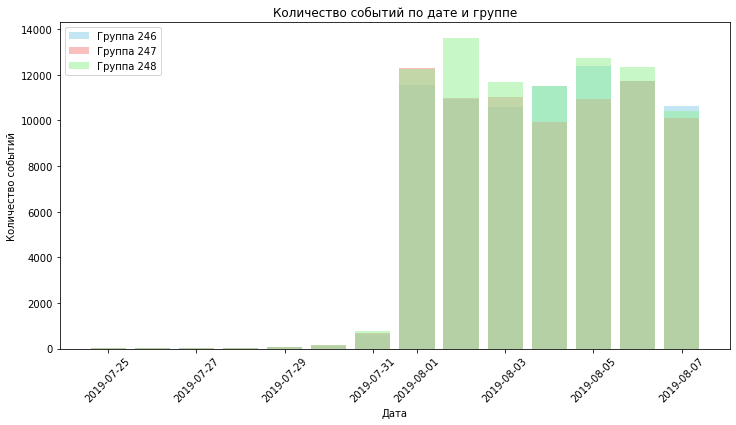

In [12]:
# группируем данные по дате и группе, считаем количество событий
events_by_date_group = data.groupby(['event_date', 'group'])['event_name'].count().reset_index()

# определяем уникальные названия групп
group_names = events_by_date_group['group'].unique()

# строим гистограмму
colors = ['skyblue', 'lightcoral', 'lightgreen']
plt.figure(figsize=(12, 6))

for i, group_name in enumerate(group_names):
    group_data = events_by_date_group[events_by_date_group['group'] == group_name]
    plt.bar(group_data['event_date'], group_data['event_name'], color=colors[i], label=f'Группа {group_name}', alpha=0.5)

plt.title("Количество событий по дате и группе")
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Больше всего событий произошло в период с 1 по 7 августа: скорее всего это период, за которые предоставлены полные данные. Отбросим всё, до 31 июля включительно. По смешению цветов на графике видно, что данные по дням в разных группах распределены приблизительно одинаково, кроме 3 августа, когда событий в группе 248 случилось чуть заметнее больше, чем в двух других группах.

In [13]:
# выделим данные за актуальный период
actual_data = data[data['event_date'] > '2019-07-31']

In [14]:
# общее количество событий и пользователей до фильтрации
total_events_before = len(data)
total_users_before = data['user_id'].nunique()

# общее количество событий и пользователей после фильтрации
total_events_after = len(actual_data)
total_users_after = actual_data['user_id'].nunique()

# расчет потерянных событий и пользователей
lost_events = total_events_before - total_events_after
lost_users = total_users_before - total_users_after

# расчет и вывод процентных потерь (округленных до 2 знаков после запятой)
percent_events_lost = round((lost_events / total_events_before) * 100, 2)
percent_users_lost = round((lost_users / total_users_before) * 100, 2)

print("\033[1mПотерянные события после фильтрации данных:\033[0m", lost_events, "или", percent_events_lost, "%")
print("\033[1mПотерянные пользователи после фильтрации данных:\033[0m", lost_users, "или", percent_users_lost, "%")

Потерянные события после фильтрации данных: 2826 или 1.16 %
Потерянные пользователи после фильтрации данных: 17 или 0.23 %


In [15]:
groups = actual_data.groupby('group').agg({'user_id':'nunique'})
groups

,user_id
group,
246,2484
247,2513
248,2537


Было потеряно менее 1% пользователей. В отфильтрованных данных присутствуют пользователи из всех трех групп.

**Выводы**. В результате проверки мы выделили период, за который предоставлены полные данные: это 1-7 августа 2019 года.

## Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются.

In [16]:
# подсчет числа событий каждого типа
event_counts = actual_data['event_name'].value_counts().reset_index()
event_counts.columns = ['event', 'frequency']
event_counts.sort_values(by='frequency', ascending=False)

,event,frequency
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Чаще всего пользователи просматривают главную страницу `MainScreenAppear`. Затем по порядку: страницу с предложениями, страницу корзины, страницу проведенной оплаты. Наименее часто встречается событие обучения `Tutorial`.

In [17]:
# считаем пользователей для каждого события
users_per_event = actual_data.groupby('event_name')['user_id'].nunique().reset_index()
users_per_event.columns = ['event', 'users']
users_per_event = users_per_event.sort_values(by='users', ascending=False)

# считаем доли пользователей, совершивших каждое событие
total_users = actual_data['user_id'].nunique()
users_per_event['user_fraction'] = (users_per_event['users'] / total_users).map('{:.2%}'.format)
users_per_event

,event,users,user_fraction
1,MainScreenAppear,7419,98.47%
2,OffersScreenAppear,4593,60.96%
0,CartScreenAppear,3734,49.56%
3,PaymentScreenSuccessful,3539,46.97%
4,Tutorial,840,11.15%


Порядок совпадает с порядком распределения количества событий. Исходя из этого построим воронку: 
1. Просмотр главной страницы  
2. Просмотр предложения 
3. Просмотр корзины 
4. Просмотр страницы проведенной оплаты

Поскольку просмотр инструкции/обучение не являются обязательным этапом, ведущим к продаже, а также выполняется всего лишь 11% пользователей, мы не будем считать его частью воронки.

In [18]:
# убираем последний шаг "Tutorial" из воронки
funnel = users_per_event[users_per_event['event'] != 'Tutorial'].copy()

# рассчитываем долю пользователей, переходящих на следующий этап воронки
funnel['conversion'] = funnel['users'] / funnel['users'].shift(1)
funnel = funnel.fillna(1) # заполняем NaN в первой строке значением 1
# выведем конверсию в процентах
funnel['conversion'] = funnel['conversion'].map('{:.1%}'.format)

funnel

,event,users,user_fraction,conversion
1,MainScreenAppear,7419,98.47%,100.0%
2,OffersScreenAppear,4593,60.96%,61.9%
0,CartScreenAppear,3734,49.56%,81.3%
3,PaymentScreenSuccessful,3539,46.97%,94.8%


In [19]:
# рассчитываем разницу в количестве пользователей между этапами воронки
funnel['user_loss'] = funnel['users'].diff()
funnel

,event,users,user_fraction,conversion,user_loss
1,MainScreenAppear,7419,98.47%,100.0%,NaN
2,OffersScreenAppear,4593,60.96%,61.9%,-2826.0
0,CartScreenAppear,3734,49.56%,81.3%,-859.0
3,PaymentScreenSuccessful,3539,46.97%,94.8%,-195.0


Больше всего пользователей теряется после первого шага — просмотра главного экрана (*MainScreenAppear*).

In [20]:
# найдем долю пользователей, дошедших от первого этапа до оплаты
conversion_from_main_to_payment = funnel.iloc[-1]['users'] / funnel.iloc[0]['users']

print("Доля пользователей, дошедших от первого этапа до оплаты:", '{:.2%}'.format(conversion_from_main_to_payment))

Доля пользователей, дошедших от первого этапа до оплаты: 47.70%


**Выводы**. Мы построили воронку событий и выяснили, что до последнего этапа покупки доходит менее половины пользователей.

## Изучение результатов эксперимента

Выясним, повлияло ли изменение шрифтов на поведение пользователей приложения. 

In [21]:
groups

,user_id
group,
246,2484
247,2513
248,2537


Группы 246 и 247 — контрольные (A), 248 — экспериментальная (B). Сперва проведём A/A-тест и выясним, равны ли две контрольные группы.

В ходе проверки данных мы выяснили, что траффик разделен корректно и ни один пользователь не попал в несколько групп. Теперь проверим, что различие в количестве пользователей двух групп не превышает 1%.

In [22]:
# найдем количество пользователей в группах 246 и 247
users_246 = actual_data[actual_data['group'] == 246]['user_id'].nunique()
users_247 = actual_data[actual_data['group'] == 247]['user_id'].nunique()

# вычислим процентное различие в размерах групп
percentage_difference = ((users_247 - users_246) / users_246) * 100

print(f"Процентное различие в размерах групп 246 и 247: {percentage_difference:.2f}%")

Процентное различие в размерах групп 246 и 247: 1.17%


В данном случае различие оказалось чуть более 1%, такая погрешность кажется не критичной, поэтому будем считать, что критерий равенства количества пользователей в группах выполнен. Перейдем к проверке различий по метрикам.

In [23]:
# выделяем данные для контрольных групп без событий Tutorial
group_246 = actual_data[(actual_data['group'] == 246) & (actual_data['event_name'] != 'Tutorial')]
group_247 = actual_data[(actual_data['group'] == 247) & (actual_data['event_name'] != 'Tutorial')]

# считаем количество пользователей на каждом этапе воронки для каждой контрольной группы
group_246_metrics = group_246.groupby('event_name')['user_id'].nunique()
group_247_metrics = group_247.groupby('event_name')['user_id'].nunique()

# вычисляем разницу
difference = ((group_247_metrics - group_246_metrics) / group_246_metrics * 100).reset_index().round(2)
difference.rename(columns={'user_id': 'difference (%)'}, inplace=True)
difference

,event_name,difference (%)
0,CartScreenAppear,-2.21
1,MainScreenAppear,1.06
2,OffersScreenAppear,-1.43
3,PaymentScreenSuccessful,-3.50


Разница в количестве пользователей на каждом этапе превышает 1%, однако эта разница также не кажется критичной. Перейдём к проверке статистической значимости различий.

Поскольку мы будем сравнивать доли пользователей между контрольными группами, мы используем z-тест для разности долей. Этот тест позволит определить, статистически значимо ли различие в долях пользователей, перешедших на определенные этапы воронки. 

In [24]:
# создадим датафрейм без событий Tutorial
test_data = actual_data.query('event_name != "Tutorial"')

# создадим сводную таблицу с нужными данными 
test_pivot = test_data.pivot_table(index='event_name', columns='group',values='user_id',aggfunc='nunique').sort_values(by=246, ascending=False)
test_pivot

group,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


In [25]:
def z_test(group1, group2, alpha=0.05): 
    
    # вычисляем количество событий в первой и второй группах
    p1_events = test_pivot.loc[event, group1]
    p2_events = test_pivot.loc[event, group2] 
    
    # получаем количество уникальных пользователей в первой и второй группах
    p1_users = groups.loc[group1, 'user_id'] 
    p2_users = groups.loc[group2, 'user_id'] 
    
    # вычисляем долю пользователей, совершивших событие, в каждой группе
    p1 = p1_events / p1_users
    p2 = p2_events / p2_users 
    
    # вычисляем разницу между долями пользователей в группах
    difference = p1 - p2
    
    # вычисляем общую долю пользователей для объединенных данных
    p_combined = (p1_events + p2_events) / (p1_users + p2_users) 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    # вычисляем p-value для двустороннего теста
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print("\033[1m{}\033[0m".format(event))
    print('p-value: {:.3f}'.format(p_value))

    # проверяем статистическую значимость и выводим результат
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы")


In [26]:
# запускаем функцию для двух контрольных групп
for event in test_pivot.index:
    z_test(246, 247)

MainScreenAppear
p-value: 0.757
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы
OffersScreenAppear
p-value: 0.248
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы
CartScreenAppear
p-value: 0.229
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы
PaymentScreenSuccessful
p-value: 0.115
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы


Видим, что разница между группами ни по одному событию не имеет статистической значимости. Таким образом, все критерии выполнены и A/A-тест можно считать успешным: группы разделены корректно.

Перейдем к A/B-тесту и сравним первую контрольную группу 246 с экспериментальной 248. 

In [27]:
print("\033[1mГруппы 246 и 248\033[0m")
for event in test_pivot.index:
    z_test(246, 248)

Группы 246 и 248
MainScreenAppear
p-value: 0.295
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы
OffersScreenAppear
p-value: 0.208
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы
CartScreenAppear
p-value: 0.078
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы
PaymentScreenSuccessful
p-value: 0.212
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы


Видим, что ни по одному событию не выявлено статистически значимого различия между группами. Перейдём к сравнению второй контрольной группы.

In [28]:
print("\033[1mГруппы 247 и 248\033[0m")
for event in test_pivot.index:
    z_test(247, 248)

Группы 247 и 248
MainScreenAppear
p-value: 0.459
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы
OffersScreenAppear
p-value: 0.920
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы
CartScreenAppear
p-value: 0.579
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы
PaymentScreenSuccessful
p-value: 0.737
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы


Статистически значимое различие между группами снова не выявлено. Теперь сравним результаты с объединённой контрольной группой. 

In [29]:
# создадим столбец 'two_control_groups' в таблице test_pivot как сумму групп 246 и 247
test_pivot['two_control_groups'] = test_pivot[246] + test_pivot[247]
# добавим количество пользователей в объединенной группе
groups.loc['two_control_groups'] = groups.loc[[246, 247], 'user_id'].sum()

In [30]:
print("\033[1mСравнение с объединенной контрольной группой\033[0m")
for event in test_pivot.index:
    z_test('two_control_groups', 248)

Сравнение с объединенной контрольной группой
MainScreenAppear
p-value: 0.294
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы
OffersScreenAppear
p-value: 0.434
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы
CartScreenAppear
p-value: 0.182
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы
PaymentScreenSuccessful
p-value: 0.600
Нельзя отвергнуть нулевую гипотезу: между долями нет значимой разницы


Сравнение с объединенной контрольной группой также не выявило статистически значимой разницы.

При проверке гипотез мы выбрали стандартный уровень значимости 0.05. Всего было проведено 16 проверок, из которых 4 для A/A-теста и еще 12 для сравнения разных групп в А/B-тесте: это множественное сравнение, для которого необходимо корректировать уровень значимости, например, по методу Бонферрони, который является одним из самых распространенных, чтобы исключить вероятность ложноположительного результата. Однако, поскольку ни одна проверка не показала положительный результат, т.е. ни в одном случае мы не смогли опровергнуть нулевую гипотезу, поправка по методу Бонферрони, по сути ужесточающая критерии проверки, не изменит результат исследования.

**Выводы**. В ходе теста не удалось выявить статистически значимое различие между группами, следовательно, изменение шрифтов не повлияло на поведение пользователей.

## Выводы

В ходе исследования мы построили воронку событий, в которую входят следующие этапы: просмотр главной страницы, просмотр предложения, просмотр корзины, просмотр страницы проведенной оплаты. Мы выяснили, что до финального шага воронки — т.е. до покупки — доходят менее половины всех пользователей (48%). Больше всего пользователей (~40%) уходят после просмотра главной страницы. 

Затем мы проверили, повлияло ли изменение шрифтов на поведение пользователей. Убедившись в корректности разделения траффика с помощью A/A-теста, мы провели A/B-тест, который показал, что поведение пользователей не изменилось: статистически значимых изменений обнаружено не было. 

Исходя из результатов исследования, можно дать следующие **рекомендации**: 
1. Изменение шрифтов не повлияло на поведение пользователей в лучшую сторону и не увеличило конверсию в покупку. Однако при этом оно и не ухудшило ситуацию. Если изменение шрифтов является частью общего ребрендинга и необходимым этапом, то ввести такое изменение без потери продаж — можно. 
2. Необходимо провести анализ функциональности приложения и, в частности, привлекательность и удобство главной страницы, с которой уходит бОльшая часть пользователей.